In [0]:
!pip install "fastai==0.7.0"
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
!pip install torchtext==0.2.3

!pip install Pillow==5.3.0
!pip install image
!pip install seaborn --upgrade matplotlib
!pip install seaborn --upgrade pandas
!pip install seaborn --upgrade pillow
!pip install seaborn --upgrade plotly

In [0]:

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from google.colab import drive, files

#%reload_ext autoreload
#%autoreload 2
#%matplotlib inline
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Default Variables and Locations
PATH = '/content/drive/My Drive/FinalProject/data'
sz = 100
arch = resnet34
import shutil

In [0]:
data = ImageClassifierData.from_paths(PATH,bs=32, tfms=tfms_from_model(arch, sz))

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:04<00:00, 18533917.27it/s]


 87%|████████▋ | 155/179 [02:54<00:26,  1.09s/it, loss=3.02]

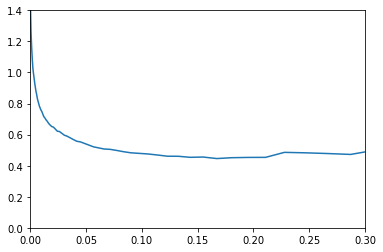

In [0]:
#Find learning rate based on the slope of loss/lr
learn = ConvLearner.pretrained(arch, data, precompute=False)
lrf = learn.lr_find()
plt.plot(learn.sched.lrs, learn.sched.losses)
plt.xlim(0, .3)
plt.ylim(0, 1.4)
plt.show()

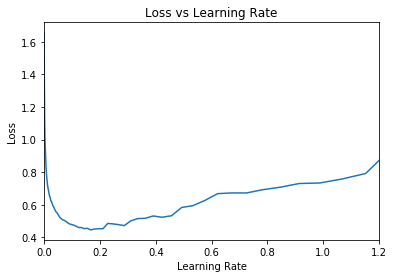

In [0]:
plt.plot(learn.sched.lrs, learn.sched.losses)
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Loss vs Learning Rate')
plt.xlim(0, 1.2)
plt.show()

Differential learning rates allow us to unfreeze layers and assign learning rates based on how similar the images are to ImageNet.

In [0]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_top_down, max_zoom=1.1,)
bs=32
def get_augs():
  data = ImageClassifierData.from_paths(PATH, bs=bs, tfms=tfms, num_workers=1)
  x, _ = next(iter(data.aug_dl))
  return data.trn_ds.denorm(x)[1]


data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)
learn = ConvLearner.pretrained(arch, data)
learn.unfreeze()
lr=np.array([1e-3, 1e-2, 1e-1])
learn.fit(lr, 2, cycle_len=2, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy   
    0      0.295308   0.09021    0.980055  
    1      0.150892   0.08011    0.988308  
    2      0.19248    0.161661   0.9663    
    3      0.083283   0.065297   0.991059  
    4      0.073875   0.055393   0.991747  
    5      0.06663    0.052383   0.991747  


[array([0.05238]), 0.9917469050894085]

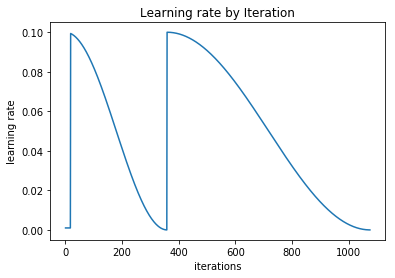

In [0]:
learn.sched.plot_lr()
plt.title('Learning rate by Iteration')
plt.show()


In [0]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds), 0)
accuracy_np(probs, y)

0.9910591471801926

# Evaluation

[[269   5   0]
 [  3 447   3]
 [  1   1 725]]


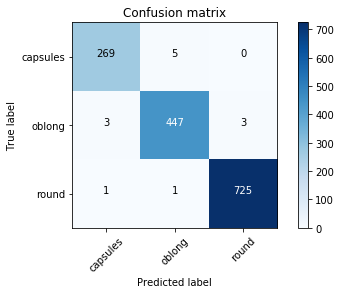

In [0]:
from sklearn.metrics import confusion_matrix
preds = np.argmax(probs, axis=1)
probs = probs[:,1]
cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, data.classes)


In [0]:
deltatest = '/content/drive/My Drive/Datasets/drugs/drugpics/oxy.jpg'
trn_tfms, val_tfms = tfms_from_model(arch,sz)
im = val_tfms(cv2.imread(deltatest)/255)
preddelta = learn.predict_array(im[None])
learn.data.classes[np.argmax(preddelta)]

'round'

In [0]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], min(len(preds), 4), replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        ims[i] = cv2.resize(ims[i], (300,200))
        plt.imshow(ims[i])
        
def load_img_id(ds, idx): return np.array(PIL.Image.open(os.path.join(PATH,ds.fnames[idx])))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')
  
  
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

most correct
most correct
most correct


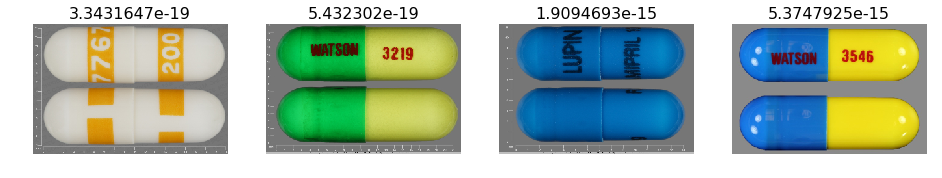

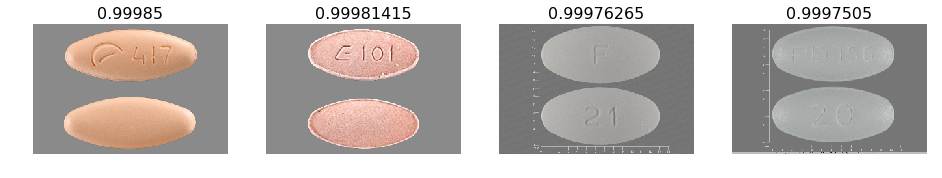

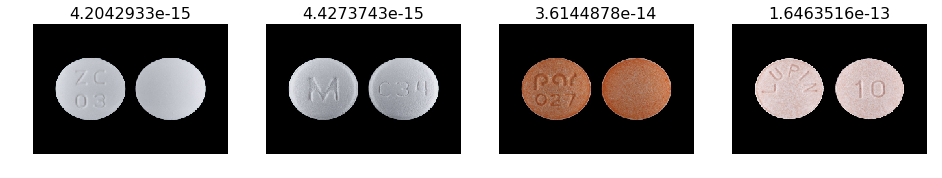

In [0]:
plot_val_with_title(most_by_correct(0,True), "most correct")
plt.show()
plot_val_with_title(most_by_correct(1,True), "most correct")
plt.show()
plot_val_with_title(most_by_correct(2,True), "most correct")

plt.show()

most incorrect


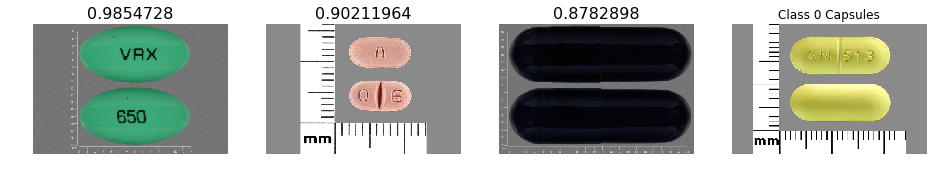

most incorrect


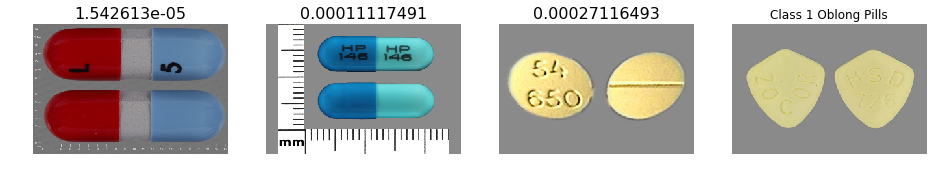

most incorrect


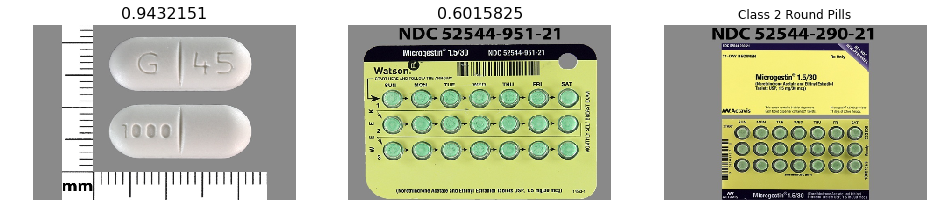

In [0]:
plot_val_with_title(most_by_correct(0,False), "most incorrect")
plt.title('Class 0 Capsules')
plt.show()
plot_val_with_title(most_by_correct(1,False), "most incorrect")
plt.title('Class 1 Oblong Pills')
plt.show()
plot_val_with_title(most_by_correct(2,False), "most incorrect")
plt.title('Class 2 Round Pills')
plt.show()

Most uncertain predictions


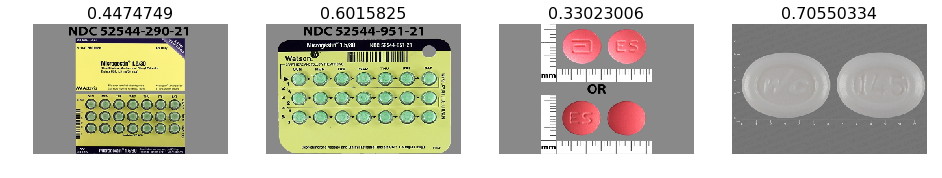

In [0]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")